# **Trabalho de Programação Estatística - Problema dos Sobrenomes de Galton**

**Integrantes do grupo:**

Julia Machado Saidel Ribeiro - RA: 812744

Marcela Jacob Moreira de Souza - RA: 832282

Pedro Henrique de Araujo - RA: 831235


##**Introdução**






O problema dos sobrenomes de Galton é um dos exemplos mais famosos de processos de ramificação. Popularizado no século XIX, ele busca estimar a probabilidade de extinção de uma linhagem ao longo das gerações. Este trabalho tem como objetivo simular o problema da extinção dos sobrenomes por meio de códigos em R e apresentar tabelas e gráficos que clareem as seguintes perguntas:


* Sob quais condições o processo de ramificação se extingue?
* A distribuição dos descendentes da linhagem influencia no comportamento das gerações?
* Há casos em que o processo sempre extinguirá? Ou sempre sobreviverá?

## **Modelo Gerador**



O modelo usado para simular o problema dos sobrenomes de Galton é conhecido como processo de ramificação de Galton-Watson.

Primeiramente, gera-se uma única partícula (ancestral) na geração $G_0$.  Esse partícula possuirá um número $X$ de descendentes que será uma variável aleatória independente e identicamente distribuída com uma distribuição de prole $D$.

Desse modo, para $Z_k$ sendo o número de partículas na geração $G_k$, temos que $Z_{k+1} = \sum_{j=1}^{Z_k}X_j$, tal que $X_j \sim D$, isto é, o número de filhos da geração $J$ segue uma distribuição $D$.

O processo pode ser dado como extinto se, em alguma geração $G_k$, $Z_k = 0$.

## **Metodologia de Simulação**








A simulação do processo de ramificação de Galton-Watson será feita da seguinte maneira:
1. A geração $k=0$ é iniciada com $Z_0=1$;
2. Para cada geração $k$, enquanto $Z_k > 0$,
    * São gerados $Z_k$ números aleatórios da distribuição de prole $D$;
    * Calcula-se a nova população $Z_{k+1}$ como a soma desses números aleatórios;
    * $k$ é incrementado.
3. Quando $Z_k = 0$, o processo se dá como extinto na geração $k$ e possui um tempo de extinção registrado. Caso a população cresça para números muito grandes, o processo será considerado não-extinto.

Apresentando, agora, as funções que desenvolvemos com o objetivo de gerar processos de ramificação de Galton-Watson seguindo duas distribuições em específico:
* Poisson($\lambda$), onde $\lambda$ representa o número médio de filhos por geração;
* Binomial($n$, $p$), onde $n$ representa o número máximo de filhos por geração com probabilidade $p$ de ocorrer.


In [9]:
set.seed(123)

#Pacotes usados para os código
library(ggplot2)
library(dplyr)

In [10]:
#Função para processo de ramificação de Galton-Watson usando a distribuição Poisson como distribuição de prole

simula_poisson <- function(lambda, M, limite_pop, df=FALSE){
  extincao <- 0  #Número de processos que irão se extinguir
  nao_extincao <- 0  #Número de processos que irão sobreviver
  tempo_extincao <- numeric(M)  #Vetor que armazena o tempo de extinção de cada simulação
  j <- 1

  for(i in 1:M){
    Zk <- 1  #Começamos com 1 partícula ancestral
    k <- 0  #Indica o número da geração

    while(Zk > 0 && Zk < limite_pop){
      desc <- rpois(Zk, lambda)  #Gerando Z_k descendentes seguindo distribuição Poisson
      Zk <- sum(desc)  #Gerando a nova população
      k <- k+1

      #Caso em que o processo se extingue
      if(Zk == 0){
        extincao <- extincao+1
        tempo_extincao[j] <- k
        j <- j+1
        break
      }
    }

    #Caso em que o processo sobrevive
    if(Zk >= limite_pop){
      nao_extincao <- nao_extincao+1
      }
    }

  tempo_extincao <- tempo_extincao[1:extincao]  #Reduzindo o vetor dos tempos de extinção ao número de processos extintos

  if(!df){
    cat("Número de processos extintos:", extincao, "\n")
    cat("Número de processos não extintos:", nao_extincao, "\n")
    cat("Probabilidade de extinção:", extincao/M, "\n")
    cat("Tempo médio de extinção:", mean(tempo_extincao), "\n")
    return(invisible(NULL))
  }

  #Data frame do tempo de extinção para cada simulação que se extinguiu
  tempo_extincao_df <- data.frame(
    n_simulacao = 1:extincao,
    tempo_extincao = tempo_extincao
  )

  return(tempo_extincao_df)
}

In [11]:
#Função para processo de ramificação de Galton-Watson usando a distribuição Binomial como distribuição de prole

simula_bin <- function(n, p, M, limite_pop, df=FALSE){
  extincao <- 0
  nao_extincao <- 0
  tempo_extincao <- numeric(M)
  j <- 1

  for(i in 1:M){
    Zk <- 1
    k <- 0

    while(Zk > 0 && Zk < limite_pop){
      desc <- rbinom(Zk, n, p)  #Gerando Z_k descendentes seguindo distribuição binomial
      Zk <- sum(desc)
      k <- k+1

      if(Zk == 0){
        extincao <- extincao+1
        tempo_extincao[j] <- k
        j <- j+1
        break
      }
    }

    if(Zk >= limite_pop){
      nao_extincao <- nao_extincao+1
      }
    }

  tempo_extincao <- tempo_extincao[1:extincao]
  if(!df){
    cat("Número de processos extintos:", extincao, "\n")
    cat("Número de processos não extintos:", nao_extincao, "\n")
    cat("Probabilidade de extinção:", extincao/M, "\n")
    cat("Tempo médio de extinção:", mean(tempo_extincao), "\n")
    return(invisible(NULL))
  }

  tempo_extincao <- tempo_extincao[1:extincao]
  tempo_extincao_df <- data.frame(
    n_simulacao = 1:extincao,
    tempo_extincao = tempo_extincao
  )

  return(tempo_extincao_df)
}

## **Experimentos e Métricas**


O experimento será investigado em 3 regimes diferente  para as distribuições apresentadas:
1. Regime **subcrítico**: $\mathbb{E}(X) < 1$ e a extinção é garantida;
2. Regime **crítico**: $\mathbb{E}(X) = 1$ e a extinção é garantida;
3. Regime **supercrítico**: $\mathbb{E}(X) > 1$ e a extinção nem sempre é garantida.

Para cada um dos regimes, serão utilizadas as funções criadas dos processos de ramificação, gerando $M = 10000$ simulações, e com o limite populacional de $10^6$ descendentes em alguma geração para declarar sobrevivência do processo.

As saídas das funções apresentarão, dentre as $M$ simulações:
* Número de processos que se extinguiram e sobreviveram;
* Probabilidade de extinção (frequência de trajetórias que se extinguiram);
* Tempo médio de extinção.


Escolhemos, arbitrariamente, os seguintes parâmetros para as distribuições:
* Poisson($0.8$), Poisson($1$) e Poisson($1.2$);
* Binomial($2, 0.4$), Binomial($2, 0.5$) e Binomial($2,  0.6$).


**Simulações para a distribuição Poisson:**

1. Poisson($0.8$) - regime subcrítico

In [ ]:
simula_poisson(0.8, 10000, 10^6)

Número de processos extintos: 10000 
Número de processos não extintos: 0 
Probabilidade de extinção: 1 
Tempo médio de extinção: 2.9094 


2. Poisson($1$) - regime crítico

In [ ]:
simula_poisson(1, 10000, 10^6)

Número de processos extintos: 10000 
Número de processos não extintos: 0 
Probabilidade de extinção: 1 
Tempo médio de extinção: 31.4118 


3. Poisson($1.2$) - regime supercrítico

In [ ]:
simula_poisson(1.2, 10000, 10^6)

Número de processos extintos: 6825 
Número de processos não extintos: 3175 
Probabilidade de extinção: 0.6825 
Tempo médio de extinção: 3.085714 


4. Poisson($2$) - regime supercrítico

In [ ]:
simula_poisson(2, 10000, 10^6)

Número de processos extintos: 2012 
Número de processos não extintos: 7988 
Probabilidade de extinção: 0.2012 
Tempo médio de extinção: 1.5333 


**Simulações para a distribuição Binomial:**

1. Bin($2, 0.4$) - regime subcrítico

In [ ]:
simula_bin(2, 0.4, 10000, 10^6)

Número de processos extintos: 10000 
Número de processos não extintos: 0 
Probabilidade de extinção: 1 
Tempo médio de extinção: 3.5169 


2. Bin($2, 0.5$) - regime crítico

In [14]:
simula_bin(2, 0.5, 10000, 10^6)

Número de processos extintos: 10000 
Número de processos não extintos: 0 
Probabilidade de extinção: 1 
Tempo médio de extinção: 42.3479 


3. Bin($2, 0.6$) - regime supercrítico

In [ ]:
simula_bin(2, 0.6, 10000, 10^6)

Número de processos extintos: 4433 
Número de processos não extintos: 5567 
Probabilidade de extinção: 0.4433 
Tempo médio de extinção: 3.464471 


## **Gráficos e Tabelas**

In [ ]:
#Data frames dos tempos de extinçãos para cada regime (Poisson)

df_poisson_subcritica <- simula_poisson(0.8, 10000, 10^6, df=TRUE)
df_poisson_critica <- simula_poisson(1, 10000, 10^6, df=TRUE)
df_poisson_supercritica <- simula_poisson(1.2, 10000, 10^6, df=TRUE)
df_poisson_supercritica2 <- simula_poisson(2, 10000, 10^6, df=TRUE)

#Data frames dos tempos de extinção para cada regime (Binomial)
df_bin_subcritica <- simula_bin(2, 0.4, 10000, 10^6, df=TRUE)
df_bin_critica <- simula_bin(2, 0.5, 10000, 10^6, df=TRUE)
df_bin_supercritica <- simula_bin(2, 0.6, 10000, 10^6, df=TRUE)

 **Tabela 1:** Medidas de posição e dispersão do tempo de extinção de 10000 simulações do processo de ramificação usando distribuição Poisson


In [ ]:
descritivas_poisson <- function(df, valor_lambda) {
  df %>%
    summarise(
      lambda = valor_lambda,
      n = n(),
      media = mean(tempo_extincao, na.rm = TRUE),
      mediana = median(tempo_extincao, na.rm = TRUE),
      minimo = min(tempo_extincao, na.rm = TRUE),
      maximo = max(tempo_extincao, na.rm = TRUE),
      desvio_padrao = sd(tempo_extincao, na.rm = TRUE),
      q1 = quantile(tempo_extincao, 0.25, na.rm = TRUE),
      q3 = quantile(tempo_extincao, 0.75, na.rm = TRUE)
    )
}

tabela_descritivas_poisson <- bind_rows(
  descritivas_poisson(df_poisson_subcritica, '0.8'),
  descritivas_poisson(df_poisson_critica, '1'),
  descritivas_poisson(df_poisson_supercritica,'1.2'),
  descritivas_poisson(df_poisson_supercritica2,'2.0')
)

tabela_descritivas_poisson

lambda,n,media,mediana,minimo,maximo,desvio_padrao,q1,q3
<chr>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
0.8,10000,2.952900,2,1,39,3.207540,1,4
1,10000,14.468500,2,1,17322,187.902847,1,6
1.2,6804,3.184891,2,1,37,3.729605,1,4
2.0,2060,1.560194,1,1,9,1.010757,1,2


Analisando as medidas descritivas para a distribuição Poisson, observarmos que o regime crítico possui $100$% de chance de extinção, porém comparado com o regime subcrítico, sua extinção tende a demorar mais gerações para acontecer. Além disso, o regime supercrítico possui a menor probabilidade de extinção, porém os processos extintos, em sua grande maioria, se extinguem na geração $Z_0$ ou $Z_1$, ou seja, para esse regime, se um processo chega à sua 2ª geração, há grande chances de sobrevivência eterna.

**Tabela 2:** Medidas de posição e dispersão do tempo de extinção de 10000 simulações do processo de ramificação usando distribuição binomial

In [ ]:
descritivas_bin <- function(df, parametros) {
  df %>%
    summarise(
      parametros = parametros,
      n = n(),
      media = mean(tempo_extincao, na.rm = TRUE),
      mediana = median(tempo_extincao, na.rm = TRUE),
      minimo = min(tempo_extincao, na.rm = TRUE),
      maximo = max(tempo_extincao, na.rm = TRUE),
      desvio_padrao = sd(tempo_extincao, na.rm = TRUE),
      q1 = quantile(tempo_extincao, 0.25, na.rm = TRUE),
      q3 = quantile(tempo_extincao, 0.75, na.rm = TRUE)
    )
}

tabela_descritivas_bin <- bind_rows(
  descritivas_bin(df_bin_subcritica, '(2, 0.4)'),
  descritivas_bin(df_bin_critica, '(2, 0.5)'),
  descritivas_bin(df_bin_supercritica, '(2, 0.6)')
)

tabela_descritivas_bin

parametros,n,media,mediana,minimo,maximo,desvio_padrao,q1,q3
<chr>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
"(2, 0.4)",10000,3.530800,2,1,46,3.685052,1,4
"(2, 0.5)",10000,48.369900,4,1,114346,1317.401436,1,11
"(2, 0.6)",4435,3.500113,2,1,34,3.582482,1,4


Assim como nas simulações usando distribuição Poisson, com a distribuição binomial o regime crítico - Binomial $(2, 0.5)$ - continua extinguindo os processos em 100% das simulações, porém com um tempo médio de extinção maior em comparação com o regime subcrítico - Binomial $(2, 0.4)$ -, em razão de em algumas simulações o número de gerações geradas ter sido muito grande.

In [7]:
#Código que gera a tabela com os resultados das 6 distribuições diferentes

medidas <- function(df, dist, media){
  M <- 10000
  data.frame(
    distribuicao = dist,
    media = media,
    n_extintos = nrow(df),
    tempo_medio_extincao = mean(df$tempo_extincao, na.rm = TRUE),
    prob_extincao = nrow(df)/M
  )
}


poisson_1 <- medidas(df_poisson_subcritica, 'Poisson(0.8)', 0.8)
poisson_2 <- medidas(df_poisson_critica, 'Poisson(1)', 1)
poisson_3 <- medidas(df_poisson_supercritica, 'Poisson(1.2)', 1.2)
poisson_4 <- medidas(df_poisson_supercritica2, 'Poisson(2)', 2)

bin_1 <- medidas(df_bin_subcritica, 'Bin(2, 0.4)', 2*0.4)
bin_2 <- medidas(df_bin_critica, 'Bin(2, 0.5)', 2*0.5)
bin_3 <- medidas(df_bin_supercritica, 'Bin(2, 0.6)', 2*0.6)

tabela_comparacao <- bind_rows(poisson_1, bin_1, poisson_2, bin_2, poisson_3, bin_3)

**Tabela 3:** Comparação do tempo de extinção das simulações para as distribuições Poisson e Binomial com média $\mathbb{E}(X) < 1$  

In [ ]:
tabela_subcritico <- tabela_comparacao |> filter(media == 0.8)
tabela_subcritico

distribuicao,media,n_extintos,tempo_medio_extincao,prob_extincao
<chr>,<dbl>,<int>,<dbl>,<dbl>
Poisson(0.8),0.8,10000,2.9529,1
"Bin(2, 0.4)",0.8,10000,3.5308,1


**Tabela 4:** Comparação do tempo de extinção das simulações para as distribuições Poisson e Binomial com média $\mathbb{E}(X) = 1$  

In [ ]:
tabela_critico <- tabela_comparacao |> filter(media == 1)
tabela_critico

distribuicao,media,n_extintos,tempo_medio_extincao,prob_extincao
<chr>,<dbl>,<int>,<dbl>,<dbl>
Poisson(1),1,10000,14.4685,1
"Bin(2, 0.5)",1,10000,48.3699,1


**Tabela 5:** Comparação do tempo de extinção das simulações para as distribuições Poisson e Binomial com média $\mathbb{E}(X) > 1$  

In [ ]:
tabela_supercritico <- tabela_comparacao |> filter(media == 1.2)
tabela_supercritico

distribuicao,media,n_extintos,tempo_medio_extincao,prob_extincao
<chr>,<dbl>,<int>,<dbl>,<dbl>
Poisson(1.2),1.2,6804,3.184891,0.6804
"Bin(2, 0.6)",1.2,4435,3.500113,0.4435


Como visto nas tabelas comparativas, as distribuições apresentam comportamentos semelhantes quando possuem a mesma média. Uma observação interessante a ser feita é o fato da distribuição binomial apresentar valores de tempo médio de extinção um pouco maiores do que a distribuição Poisson. Isso pode ocorrer por conta do tempo máximo de extinção dentre as $M = 10000$ simulações também ser maior que a Poisson nos 3 regimes.

**Gráfico 1:** Histogramas comparativos da distribuições do tempos de extinção nas simulações utilizando distribuições Poisson e Binomial

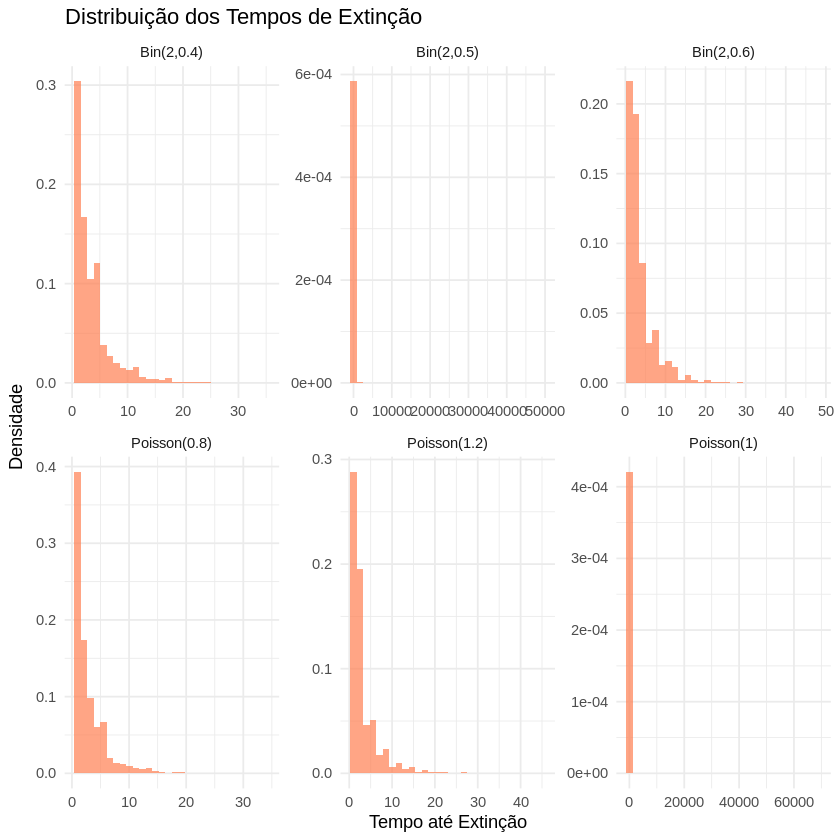

In [13]:
df_completo <- bind_rows(
  df_poisson_subcritica %>% mutate(distribuicao = "Poisson(0.8)", media = 0.8, regime = 'Subcrítico'),
  df_bin_subcritica %>% mutate(distribuicao = "Bin(2,0.4)", media = 0.8, regime = 'Subcrítico'),
  df_poisson_critica %>% mutate(distribuicao = "Poisson(1)", media = 1.0, regime = 'Crítico'),
  df_bin_critica %>% mutate(distribuicao = "Bin(2,0.5)", media = 1.0, regime = 'Crítico'),
  df_poisson_supercritica %>% mutate(distribuicao = "Poisson(1.2)", media = 1.2, regime = 'Supercrítico'),
  df_bin_supercritica %>% mutate(distribuicao = "Bin(2,0.6)", media = 1.2, regime = 'Supercrítico')
)

ggplot(df_completo, aes(x = tempo_extincao)) +
  geom_histogram(aes(y = after_stat(density)), bins = 30, alpha = 0.7, fill = "coral") +
  facet_wrap(~distribuicao, scales = "free") +
  labs(title = "Distribuição dos Tempos de Extinção",
       x = "Tempo até Extinção",
       y = "Densidade") +
  theme_minimal()

Vemos nos histogramas para cada uma das distribuições que o comportamento do tempo de extinção tanto para a Poisson quanto para a Binomial são semelhantes quando possuem a mesma média. Além disso, percebemos que a distribuição do tempo de extinção para os regimes subcríticos e supercríticos é muito parecido, se aproximando de uma distribuição exponencial.

**Gráfico 2:** Gráfico de barras comparativo dos tempos médios de extinção para cada regime simulado

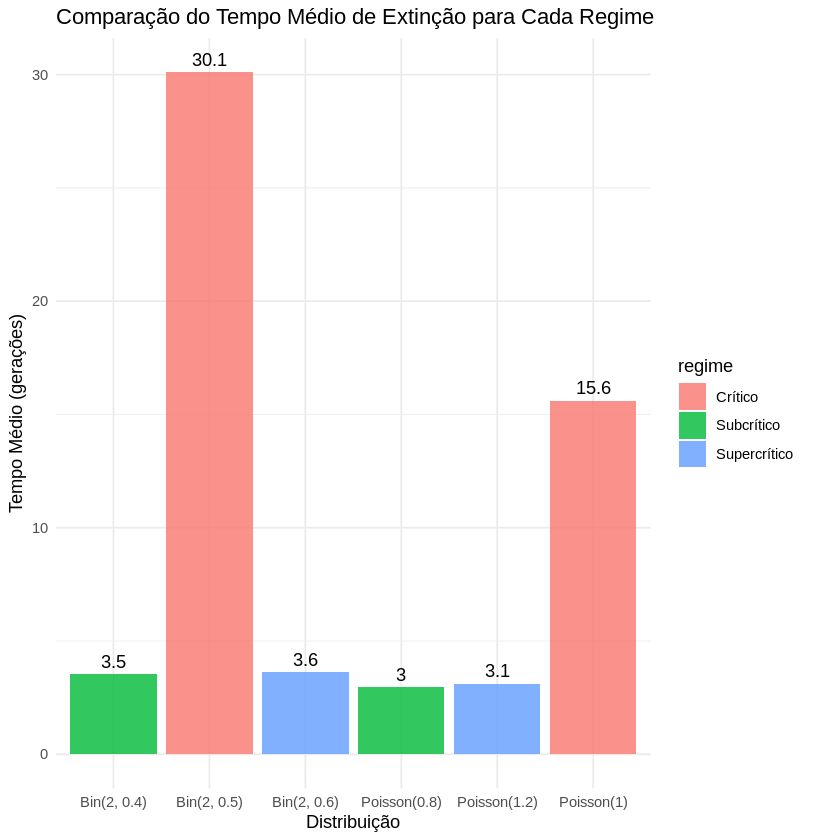

In [ ]:
comparacao_direta <- tabela_comparacao %>%
  mutate(regime = case_when(
    media < 1 ~ "Subcrítico",
    media == 1 ~ "Crítico",
    media > 1 ~ "Supercrítico"
  ))

ggplot(comparacao_direta, aes(x = distribuicao, y = tempo_medio_extincao, fill = regime)) +
  geom_col(position = "dodge", alpha = 0.8) +
  geom_text(aes(label = round(tempo_medio_extincao, 1)),
            position = position_dodge(width = 0.9), vjust = -0.5) +
  labs(title = "Comparação do Tempo Médio de Extinção para Cada Regime",
       x = "Distribuição",
       y = "Tempo Médio (gerações)") +
  theme_minimal()

Como já foi dito anteriormente, os tempos médios de extinção para os regimes subcrítico e supercrítico são semelhantes para as duas distribuições, diferindo apenas no regime crítico, em que o tempo da Binomial é um pouco mais elevado por conta de possuir simulações que obtiveram mais gerações do que o esperado.

**Gráfico 3:** Boxplots comparativos da distribuição dos tempos de extinção das distribuições Poisson e Binomial

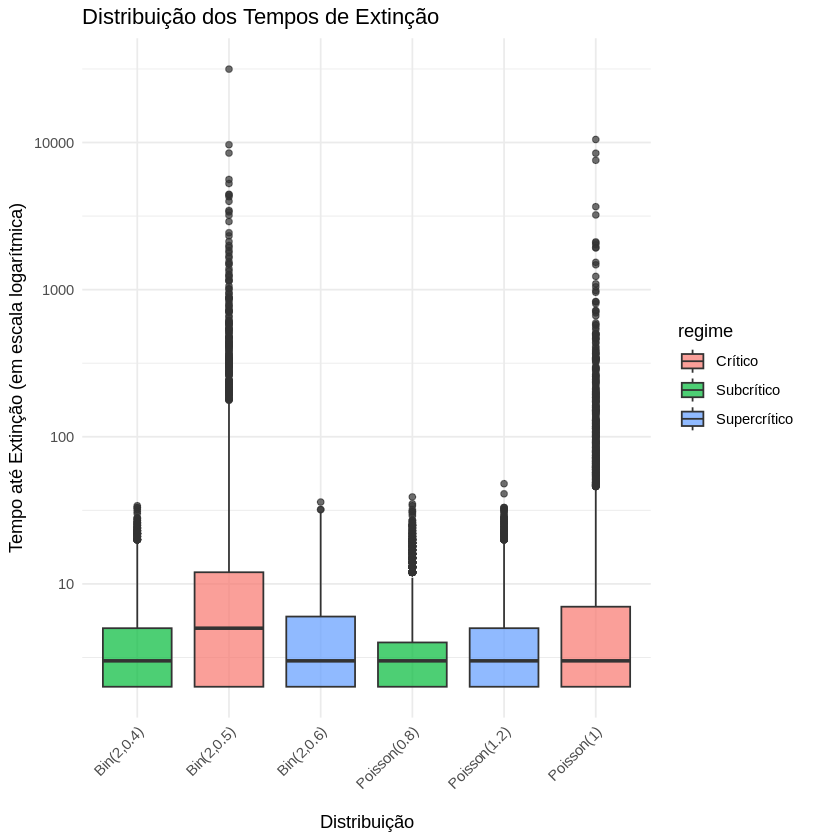

In [ ]:
ggplot(df_completo, aes(x = distribuicao, y = tempo_extincao + 1, fill = regime)) +
  geom_boxplot(alpha = 0.7) +
  scale_y_log10() +
  labs(
    title = "Distribuição dos Tempos de Extinção",
    x = "Distribuição",
    y = "Tempo até Extinção (em escala logarítmica)"
  ) +
  theme_minimal() +
  theme(axis.text.x = element_text(angle = 45, hjust = 1))

Como dito anteriormente, conseguimos ver que não há muita diferença nos boxplots para os regimes subcrítico e supercrítico para a Poisson e Binomial, ao contrário do regime crítico, em que, em ambas as distribuições, há muitos valores discrepantes, que podem afetar nas medidas de posição, dispersão e no tempo médio de extinção. Apesar disso, também vemos que, fora os outliers, o regime crítico para a Poisson e para a Binomial possuem medianas perto uma da outra.

**Gráfico 4**: Gráfico comparativo da probabilidade de extinção e da média para cada distribuição

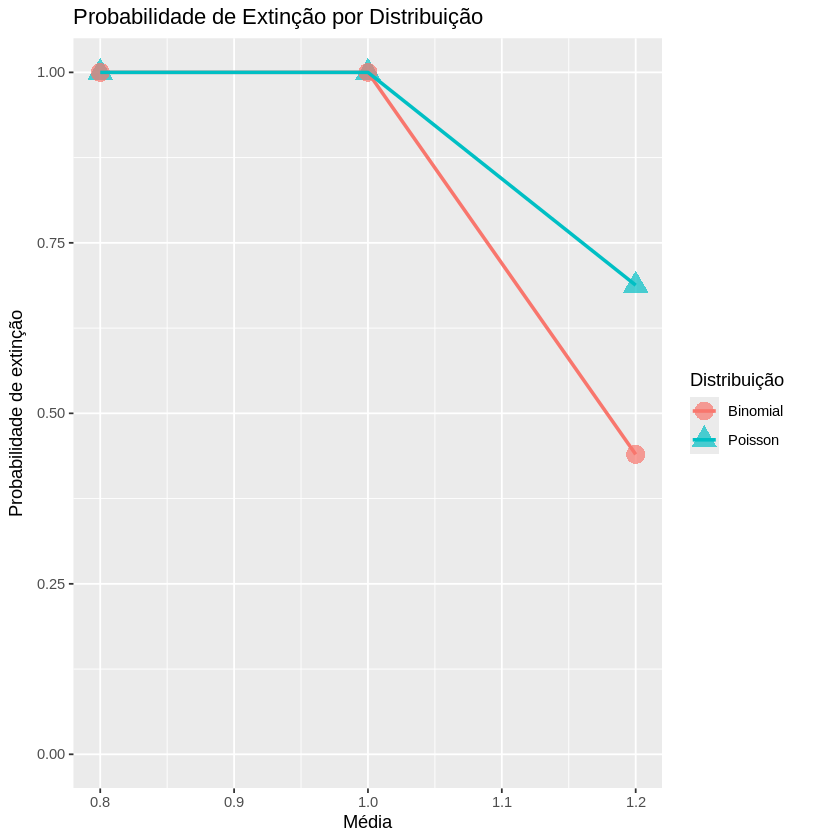

In [8]:
comparacao <- tabela_comparacao
comparacao$dist <- "Poisson"
comparacao[c(2,4,6),6] <- "Binomial"
comparacao$dist <- as.factor(comparacao$dist)

comparacao <- comparacao |> select(dist, media, prob_extincao)

ggplot(comparacao, aes(x = media, y = prob_extincao, color = dist, shape = dist)) +
  geom_point(size = 5, alpha = 0.7) +
    geom_line(linewidth = 1) +
      labs(title = "Probabilidade de Extinção por Distribuição", x = "Média", y = "Probabilidade de extinção", color = "Distribuição", shape = "Distribuição") +
        ylim(0,1)

No gráfico, podemos ver que tanto para a distribuição Binomial quanto para a Poisson a probabilidade de extinção diminui conforme a média das distribuições aumenta. Porém, a probabilidade de extinção para a Binomial diminui mais rápido que para a Poisson.

## **Conclusão**


Esse trabalho investigou o comportamento do processo de ramificação de Galton-Watson sob a perspectiva de duas distribuições diferentes - Poisson e Binomial - e como a média de cada uma dessas distribuições pode influenciar nas trajetórias do processo.
As principais respostas encontradas foram:
* Para ambas distribuições, os regimes **subcrítico** e **crítico** possuem 100% de extinção em todas as simulações, porém possuem comportamentos diferentes - enquanto o tempo médio de extinção quando $\mathbb{E}(X) < 1$ é baixo (em torno de 2/3 gerações), quando $\mathbb{E}(X) = 1$, o comportamento é bem instável, devido à grande presença de *outliers*, isto é, simulações em que o processo durou um número de gerações acima do comum.


* Para o regime **supercrítico**, a probabilidade de extinção não é sempre 100%, uma vez que há simulações em que a sobrevivência é eterna. Entretanto, foi observado no caso da Poisson que, quanto maior for a média da distribuição de prole, mais o processo se comporta no seguinte caso: ou se extingue nas primeiras gerações ou vive para sempre.


* Comparando a distribuição **Poisson** com a **Binomial**, vimos que a Poisson tem uma tendência maior a apresentar tempos de extinção menores. Isso pode se dar por conta dela ser uma distribuição com uma variância maior e pela Binomial ter um número limitado de filhos, que no nosso caso foi $2$ filhos.

Portanto, em uma linhagem, o comportamento da perpetuação de um sobrenome depende de qual distribuição a geração de descendentes segue e qual a sua média. Há casos em que um sobrenome se extingue com facilidade, porém também pode sobreviver eternamente, perpassando gerações.
